# NAS Creature Analysis

Deep analysis of evolved creatures from our NAS hyperparameter search experiments.

**Runs Analyzed:**
- 10 NEAT runs (from 100-trial and 200-trial searches)
- 8 Pure neural mode runs (from 200-trial search)

**Focus Areas:**
1. Body morphology patterns
2. Neural network strategy analysis
3. Activation patterns and locomotion
4. NEAT vs Pure comparison
5. Best creature deep-dives

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

API_BASE = "http://localhost:8000/api"

def get_runs():
    return requests.get(f"{API_BASE}/runs").json()

def get_generations(run_id):
    return requests.get(f"{API_BASE}/runs/{run_id}/generations").json()

def get_creatures(run_id, generation, limit=100):
    return requests.get(f"{API_BASE}/runs/{run_id}/generations/{generation}/creatures?limit={limit}").json()

def get_frames(creature_id, run_id, generation):
    return requests.get(f"{API_BASE}/creatures/{creature_id}/frames?run_id={run_id}&generation={generation}").json()

print("API ready")

API ready


## 1. Load All Runs

In [2]:
# Fetch all runs
all_runs = get_runs()
print(f"Total runs in database: {len(all_runs)}")

# Filter to NAS runs (have trial numbers in name)
nas_runs = [r for r in all_runs if '#' in r['name'] or 'Trial' in r['name']]
print(f"NAS trial runs: {len(nas_runs)}")

# Categorize
neat_runs = [r for r in nas_runs if r['config'].get('neural_mode') == 'neat']
pure_runs = [r for r in nas_runs if r['config'].get('neural_mode') == 'pure']

print(f"  NEAT runs: {len(neat_runs)}")
print(f"  Pure runs: {len(pure_runs)}")

Total runs in database: 27
NAS trial runs: 18
  NEAT runs: 10
  Pure runs: 8


In [3]:
# Create summary dataframe
runs_data = []
for run in nas_runs:
    config = run['config']
    runs_data.append({
        'name': run['name'],
        'id': run['id'],
        'neural_mode': config.get('neural_mode'),
        'best_fitness': run['best_fitness'],
        'generations': run['generation_count'],
        'population_size': config.get('population_size'),
        'use_proprioception': config.get('use_proprioception', False),
        'use_crossover': config.get('use_crossover', True),
        'mutation_rate': config.get('mutation_rate'),
        'weight_mutation_rate': config.get('weight_mutation_rate'),
        'max_nodes': config.get('max_nodes'),
        'max_muscles': config.get('max_muscles'),
    })

runs_df = pd.DataFrame(runs_data)
runs_df = runs_df.sort_values('best_fitness', ascending=False)
runs_df.head(10)

,name,id,neural_mode,best_fitness,generations,population_size,use_proprioception,use_crossover,mutation_rate,weight_mutation_rate,max_nodes,max_muscles
7,NEAT n100 #57 (top-best),1f6df65b-3518-4032-97fd-7e58179e7a75,neat,609.519836,100,100,False,True,0.379734,0.699888,12,12
15,Pure Trial 159 (top-best),375ca4f1-3b43-435c-aecd-6cbd4dd83bb2,pure,431.716003,100,100,True,False,0.443021,0.169549,11,16
17,Pure Trial 42 (top-best),537c54bc-179d-4549-8c5b-3c7905d5a7d6,pure,420.712158,100,100,True,False,0.575654,0.121596,9,14
14,Pure Trial 190 (top-best),2a56eb17-a55e-4277-8a07-9dfdf9e8b663,pure,414.186279,100,100,True,False,0.436743,0.499367,10,15
11,Pure p200 #165 (manual),a00aa694-c691-468f-96c0-8a9ae7e03a93,pure,330.481079,100,100,True,False,0.570065,0.316966,8,12
2,NEAT n100 #94 (manual),69d6ea41-ca05-41c5-8e5a-382ed9af6cca,neat,313.830505,100,100,False,True,0.455514,0.617069,11,12
8,NEAT n100 #68 (top-best),cf23f138-cf68-491b-8acf-be3cff48ce9e,neat,312.871979,100,100,False,True,0.526422,0.643960,12,9
3,NEAT n100 #90 (manual),80f87c37-61bf-47d0-bc75-6ed7da5243d0,neat,312.215668,100,100,False,True,0.447336,0.698806,12,10
9,Pure p200 #43 (manual),27cbd888-5b52-4ffa-83ee-a451a6af98c6,pure,298.751740,100,100,False,False,0.162462,0.448717,12,16
6,Pure p200 #118 (manual),48860320-baf2-4968-8556-16bc45befee4,pure,288.234467,100,100,True,False,0.320384,0.208659,10,11


## 2. Fitness Comparison: NEAT vs Pure

/Users/silen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/silen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/silen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


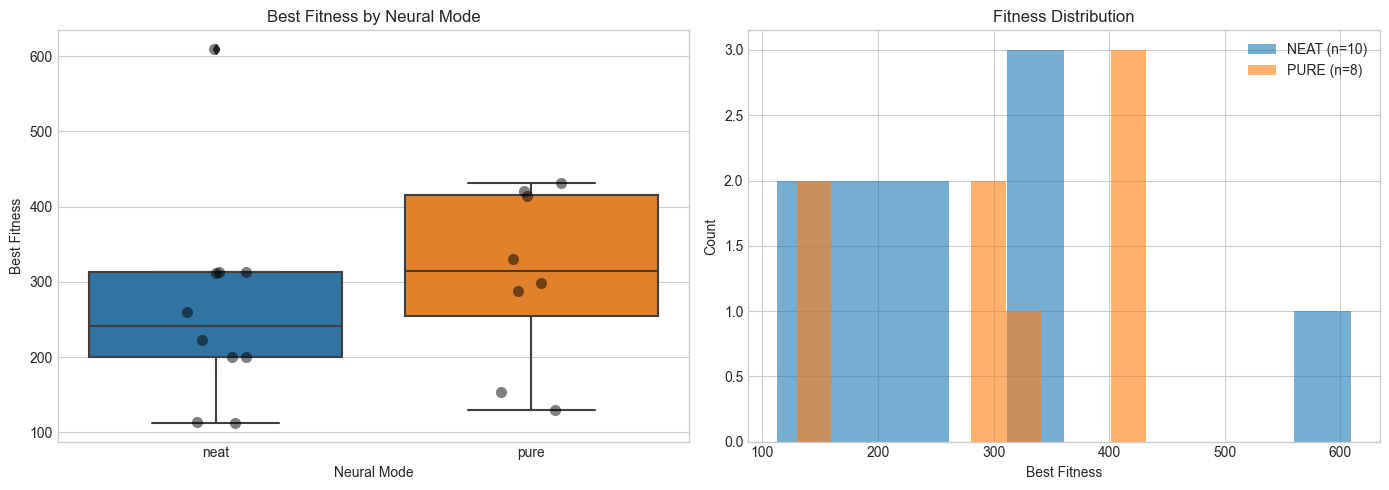


Statistics:
                   mean         std         min         max
neural_mode                                                
neat         265.777901  142.184526  112.618156  609.519836
pure         308.485674  116.952683  129.585526  431.716003


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot comparison
ax = axes[0]
sns.boxplot(data=runs_df, x='neural_mode', y='best_fitness', ax=ax)
ax.set_title('Best Fitness by Neural Mode')
ax.set_xlabel('Neural Mode')
ax.set_ylabel('Best Fitness')

# Add individual points
sns.stripplot(data=runs_df, x='neural_mode', y='best_fitness', ax=ax, 
              color='black', alpha=0.5, size=8)

# Histogram
ax = axes[1]
for mode in ['neat', 'pure']:
    subset = runs_df[runs_df['neural_mode'] == mode]
    ax.hist(subset['best_fitness'], bins=10, alpha=0.6, label=f'{mode.upper()} (n={len(subset)})')
ax.set_title('Fitness Distribution')
ax.set_xlabel('Best Fitness')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.show()

# Stats
print("\nStatistics:")
print(runs_df.groupby('neural_mode')['best_fitness'].agg(['mean', 'std', 'min', 'max']))

## 3. Load Best Creatures from Each Run

In [5]:
# Get best creature from final generation of each run
best_creatures = []

for run in nas_runs:
    run_id = run['id']
    final_gen = run['generation_count'] - 1
    
    try:
        creatures = get_creatures(run_id, final_gen, limit=5)
        if creatures:
            best = creatures[0]  # Already sorted by fitness desc
            genome = best['genome']
            
            best_creatures.append({
                'run_name': run['name'],
                'run_id': run_id,
                'creature_id': best['id'],
                'generation': final_gen,
                'fitness': best['fitness'],
                'pellets': best.get('pellets_collected', 0),
                'neural_mode': run['config'].get('neural_mode'),
                'node_count': len(genome.get('nodes', [])),
                'muscle_count': len(genome.get('muscles', [])),
                'has_frames': best.get('has_frames', False),
                'survival_streak': best.get('survival_streak', 0),
                'genome': genome,
            })
    except Exception as e:
        print(f"Error loading {run['name']}: {e}")

creatures_df = pd.DataFrame(best_creatures)
print(f"Loaded {len(creatures_df)} best creatures")
creatures_df.sort_values('fitness', ascending=False).head(10)[['run_name', 'fitness', 'pellets', 'node_count', 'muscle_count', 'neural_mode']]

Loaded 18 best creatures


,run_name,fitness,pellets,node_count,muscle_count,neural_mode
15,Pure Trial 159 (top-best),308.643799,3,9,13,pure
14,Pure Trial 190 (top-best),304.176880,3,7,9,pure
7,NEAT n100 #57 (top-best),260.210083,2,8,12,neat
8,NEAT n100 #68 (top-best),224.284897,2,7,9,neat
2,NEAT n100 #94 (manual),211.406113,2,9,12,neat
17,Pure Trial 42 (top-best),205.892929,2,8,12,pure
9,Pure p200 #43 (manual),199.615173,1,8,16,pure
10,NEAT n200 #83 (top-best),163.521530,1,6,9,neat
11,Pure p200 #165 (manual),157.513641,1,8,11,pure
12,NEAT n200 #64 (top-best),150.982483,1,6,5,neat


## 4. Body Morphology Analysis

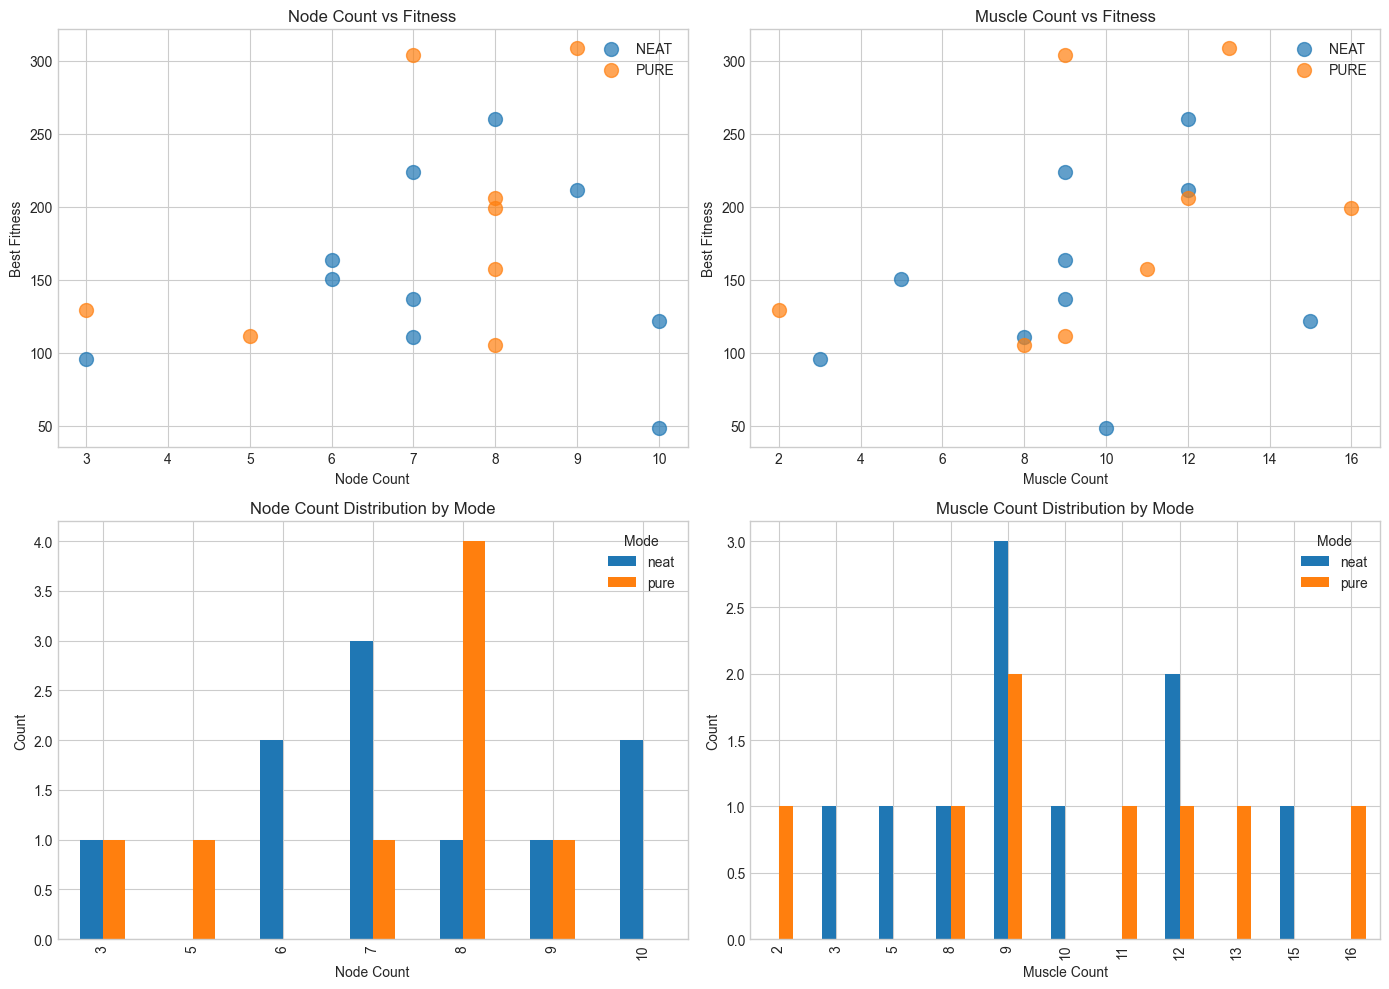


Morphology Statistics:
            node_count           muscle_count          
                  mean       std         mean       std
neural_mode                                            
neat               7.3  2.110819          9.2  3.457681
pure               7.0  2.000000         10.0  4.140393


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Node count vs Fitness
ax = axes[0, 0]
for mode in ['neat', 'pure']:
    subset = creatures_df[creatures_df['neural_mode'] == mode]
    ax.scatter(subset['node_count'], subset['fitness'], label=mode.upper(), alpha=0.7, s=100)
ax.set_xlabel('Node Count')
ax.set_ylabel('Best Fitness')
ax.set_title('Node Count vs Fitness')
ax.legend()

# Muscle count vs Fitness
ax = axes[0, 1]
for mode in ['neat', 'pure']:
    subset = creatures_df[creatures_df['neural_mode'] == mode]
    ax.scatter(subset['muscle_count'], subset['fitness'], label=mode.upper(), alpha=0.7, s=100)
ax.set_xlabel('Muscle Count')
ax.set_ylabel('Best Fitness')
ax.set_title('Muscle Count vs Fitness')
ax.legend()

# Node count distribution
ax = axes[1, 0]
creatures_df.groupby('neural_mode')['node_count'].value_counts().unstack().T.plot(kind='bar', ax=ax)
ax.set_xlabel('Node Count')
ax.set_ylabel('Count')
ax.set_title('Node Count Distribution by Mode')
ax.legend(title='Mode')

# Muscle count distribution
ax = axes[1, 1]
creatures_df.groupby('neural_mode')['muscle_count'].value_counts().unstack().T.plot(kind='bar', ax=ax)
ax.set_xlabel('Muscle Count')
ax.set_ylabel('Count')
ax.set_title('Muscle Count Distribution by Mode')
ax.legend(title='Mode')

plt.tight_layout()
plt.show()

print("\nMorphology Statistics:")
print(creatures_df.groupby('neural_mode')[['node_count', 'muscle_count']].agg(['mean', 'std']))

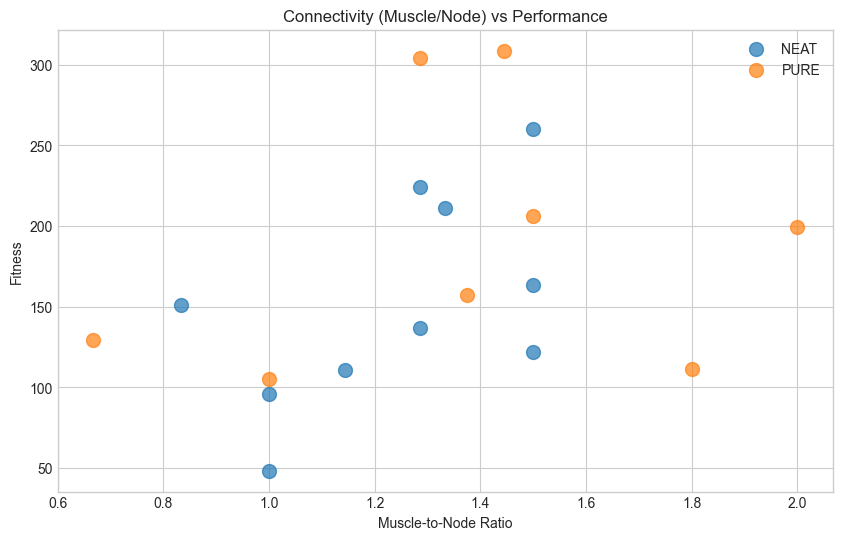


Correlation (muscle_ratio vs fitness): 0.360


In [7]:
# Muscle-to-node ratio analysis
creatures_df['muscle_ratio'] = creatures_df['muscle_count'] / creatures_df['node_count']

fig, ax = plt.subplots(figsize=(10, 6))
for mode in ['neat', 'pure']:
    subset = creatures_df[creatures_df['neural_mode'] == mode]
    ax.scatter(subset['muscle_ratio'], subset['fitness'], label=mode.upper(), alpha=0.7, s=100)
ax.set_xlabel('Muscle-to-Node Ratio')
ax.set_ylabel('Fitness')
ax.set_title('Connectivity (Muscle/Node) vs Performance')
ax.legend()
plt.show()

# Correlation
print(f"\nCorrelation (muscle_ratio vs fitness): {creatures_df['muscle_ratio'].corr(creatures_df['fitness']):.3f}")

## 5. Neural Network Analysis

Analyze the evolved neural networks - weight distributions, activation patterns, and output strategies.

In [8]:
# Extract neural genome info
neural_data = []

for idx, row in creatures_df.iterrows():
    genome = row['genome']
    neural = genome.get('neuralGenome', {})
    
    if row['neural_mode'] == 'pure':
        # Pure mode: fixed topology
        weights_ih = neural.get('weights_ih', [])
        weights_ho = neural.get('weights_ho', [])
        bias_h = neural.get('bias_h', [])
        bias_o = neural.get('bias_o', [])
        
        all_weights = weights_ih + weights_ho + bias_h + bias_o
        if all_weights:
            neural_data.append({
                'run_name': row['run_name'],
                'neural_mode': 'pure',
                'fitness': row['fitness'],
                'hidden_size': neural.get('hidden_size', 8),
                'weight_mean': np.mean(all_weights),
                'weight_std': np.std(all_weights),
                'weight_max': np.max(np.abs(all_weights)),
                'total_params': len(all_weights),
            })
    else:
        # NEAT mode: variable topology
        neat = genome.get('neat', {})
        connections = neat.get('connections', [])
        nodes = neat.get('hidden_nodes', [])
        
        if connections:
            weights = [c.get('weight', 0) for c in connections]
            enabled = sum(1 for c in connections if c.get('enabled', True))
            
            neural_data.append({
                'run_name': row['run_name'],
                'neural_mode': 'neat',
                'fitness': row['fitness'],
                'hidden_size': len(nodes),
                'weight_mean': np.mean(weights),
                'weight_std': np.std(weights),
                'weight_max': np.max(np.abs(weights)),
                'total_connections': len(connections),
                'enabled_connections': enabled,
                'total_params': len(weights),
            })

neural_df = pd.DataFrame(neural_data)
print(f"Extracted neural data for {len(neural_df)} creatures")
neural_df.head()

Extracted neural data for 8 creatures


,run_name,neural_mode,fitness,hidden_size,weight_mean,weight_std,weight_max,total_params
0,Pure p200 #118 (manual),pure,111.659866,20,0.088151,1.986765,6.570013,480
1,Pure p200 #43 (manual),pure,199.615173,24,-0.002560,2.003280,6.242405,552
2,Pure p200 #165 (manual),pure,157.513641,24,-0.059683,2.309065,7.371656,1680
3,Pure Trial 178 (top-best),pure,129.585526,4,0.042330,1.749095,3.671130,36
4,Pure Trial 190 (top-best),pure,304.176880,8,-0.009030,1.382223,4.225495,288


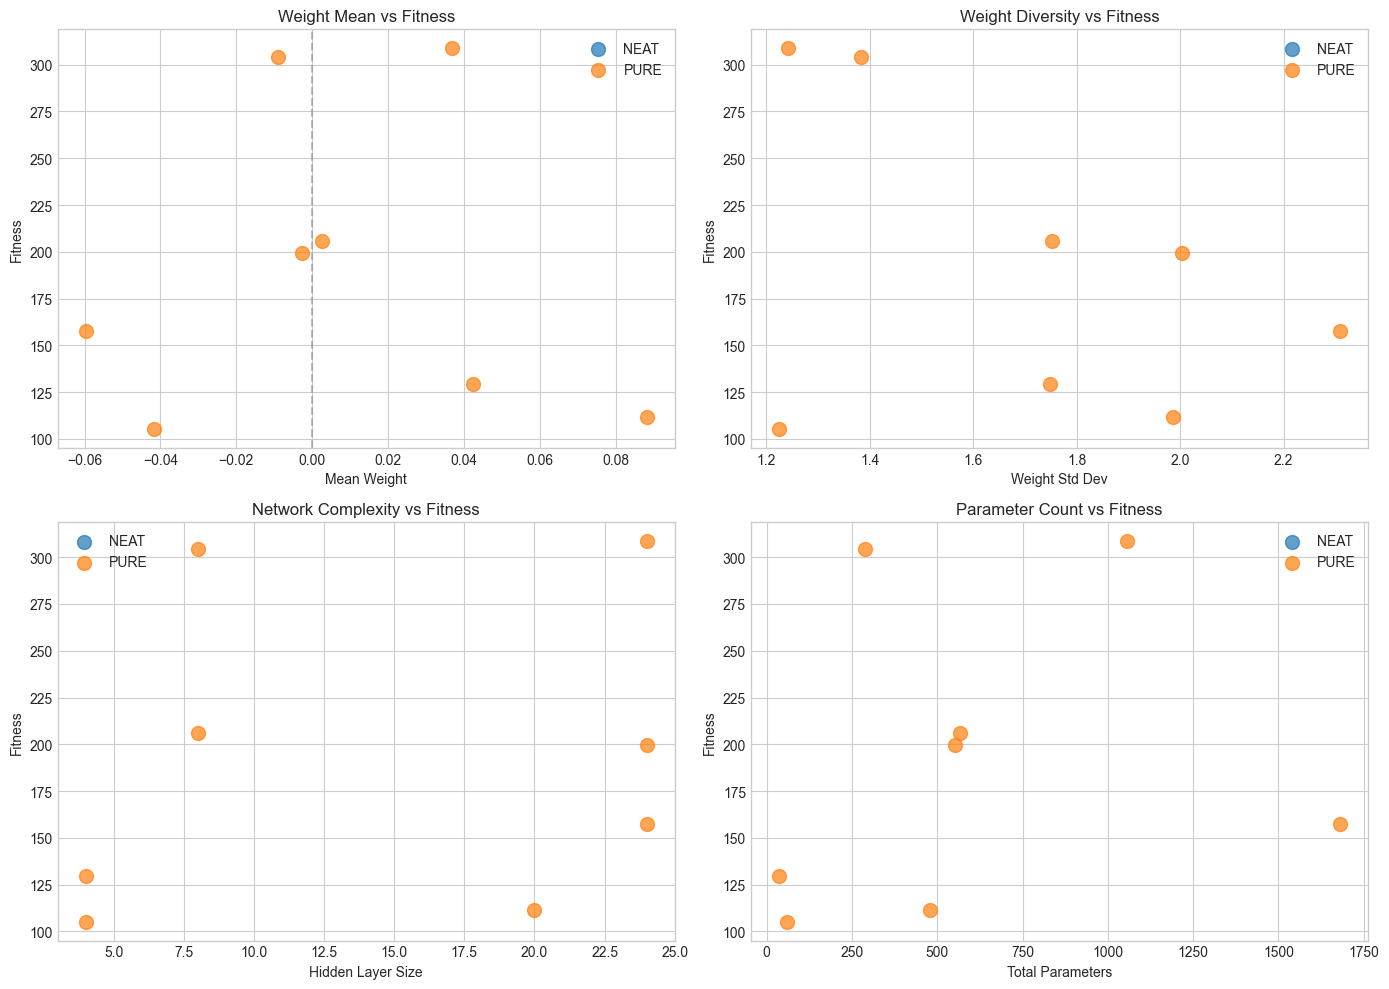

In [9]:
# Weight distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Weight mean vs fitness
ax = axes[0, 0]
for mode in ['neat', 'pure']:
    subset = neural_df[neural_df['neural_mode'] == mode]
    ax.scatter(subset['weight_mean'], subset['fitness'], label=mode.upper(), alpha=0.7, s=100)
ax.set_xlabel('Mean Weight')
ax.set_ylabel('Fitness')
ax.set_title('Weight Mean vs Fitness')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.legend()

# Weight std vs fitness  
ax = axes[0, 1]
for mode in ['neat', 'pure']:
    subset = neural_df[neural_df['neural_mode'] == mode]
    ax.scatter(subset['weight_std'], subset['fitness'], label=mode.upper(), alpha=0.7, s=100)
ax.set_xlabel('Weight Std Dev')
ax.set_ylabel('Fitness')
ax.set_title('Weight Diversity vs Fitness')
ax.legend()

# Hidden size vs fitness (NEAT evolves this!)
ax = axes[1, 0]
for mode in ['neat', 'pure']:
    subset = neural_df[neural_df['neural_mode'] == mode]
    ax.scatter(subset['hidden_size'], subset['fitness'], label=mode.upper(), alpha=0.7, s=100)
ax.set_xlabel('Hidden Layer Size')
ax.set_ylabel('Fitness')
ax.set_title('Network Complexity vs Fitness')
ax.legend()

# Total params vs fitness
ax = axes[1, 1]
for mode in ['neat', 'pure']:
    subset = neural_df[neural_df['neural_mode'] == mode]
    ax.scatter(subset['total_params'], subset['fitness'], label=mode.upper(), alpha=0.7, s=100)
ax.set_xlabel('Total Parameters')
ax.set_ylabel('Fitness')
ax.set_title('Parameter Count vs Fitness')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Activation Pattern Analysis

Load frame data and analyze neural activations over time for the best creatures.

In [10]:
# Get creatures with frame data
creatures_with_frames = creatures_df[creatures_df['has_frames']].copy()
print(f"Creatures with frame data: {len(creatures_with_frames)}")

# Load activations for top creatures
activation_data = {}

for idx, row in creatures_with_frames.nlargest(6, 'fitness').iterrows():
    try:
        frames = get_frames(row['creature_id'], row['run_id'], row['generation'])
        if frames and 'activations_per_frame' in frames:
            activation_data[row['run_name']] = {
                'activations': frames['activations_per_frame'],
                'fitness': row['fitness'],
                'neural_mode': row['neural_mode'],
                'fitness_over_time': frames.get('fitness_over_time', []),
            }
            print(f"  Loaded {len(frames['activations_per_frame'])} frames for {row['run_name']}")
    except Exception as e:
        print(f"  Error loading {row['run_name']}: {e}")

print(f"\nLoaded activation data for {len(activation_data)} creatures")

Creatures with frame data: 18
  Loaded 450 frames for Pure Trial 159 (top-best)
  Loaded 450 frames for Pure Trial 190 (top-best)
  Loaded 450 frames for NEAT n100 #57 (top-best)
  Loaded 450 frames for NEAT n100 #68 (top-best)
  Loaded 450 frames for NEAT n100 #94 (manual)
  Loaded 450 frames for Pure Trial 42 (top-best)

Loaded activation data for 6 creatures


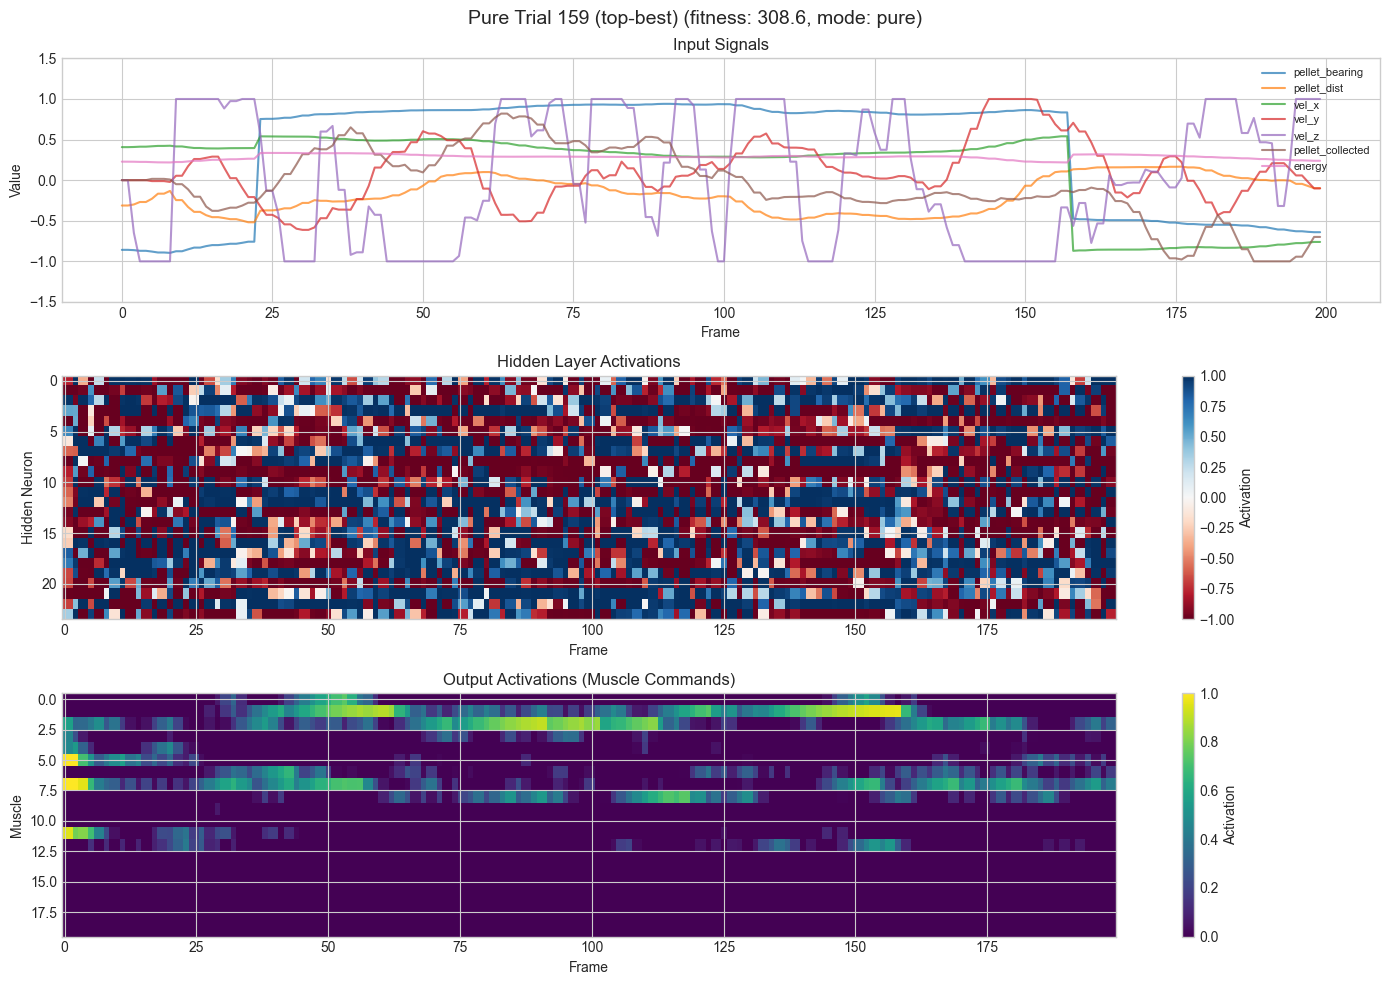

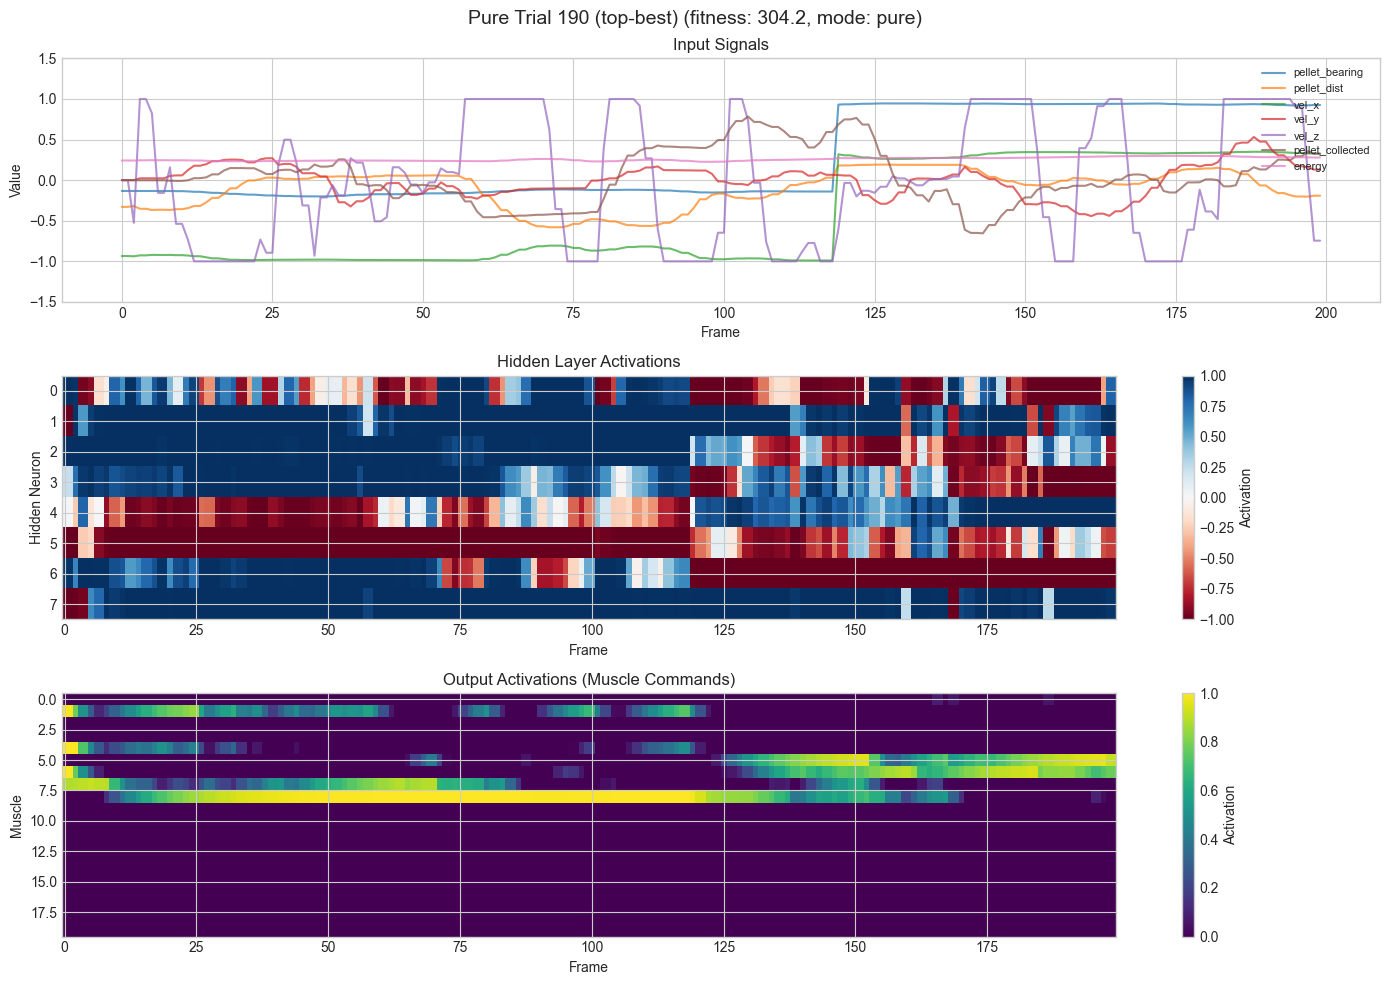

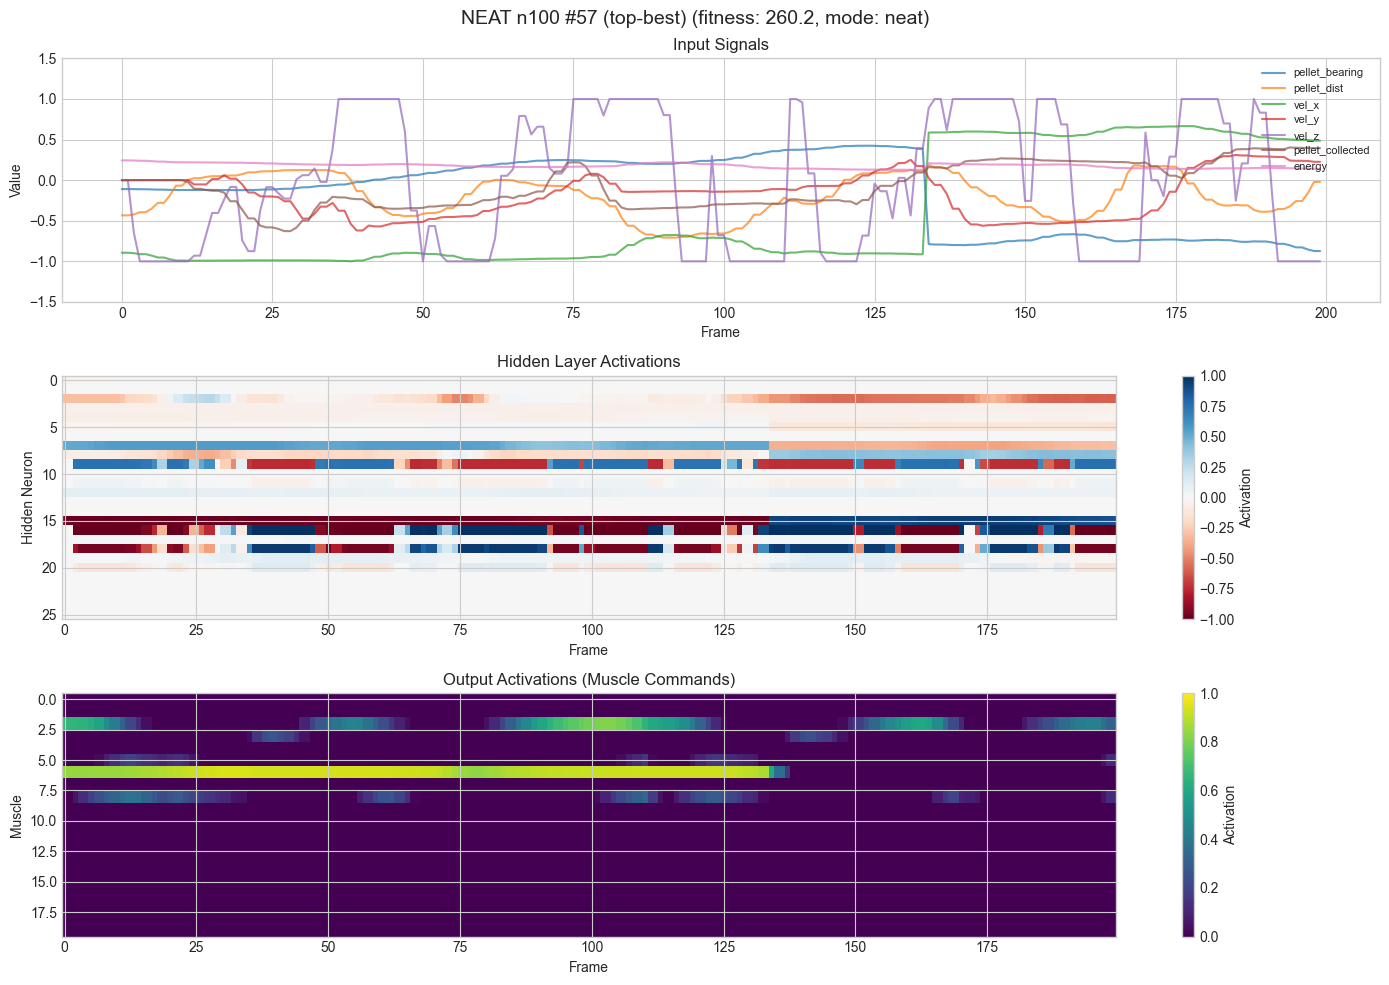

In [11]:
# Analyze activation patterns over time
def plot_activations(name, data, max_frames=200):
    activations = data['activations'][:max_frames]
    
    # Extract arrays
    inputs = np.array([a['inputs'] for a in activations])
    hidden = np.array([a['hidden'] for a in activations])
    outputs = np.array([a['outputs'] for a in activations])
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle(f"{name} (fitness: {data['fitness']:.1f}, mode: {data['neural_mode']})", fontsize=14)
    
    # Input signals over time (first 7 core inputs)
    ax = axes[0]
    core_inputs = inputs[:, :7] if inputs.shape[1] >= 7 else inputs
    input_labels = ['pellet_bearing', 'pellet_dist', 'vel_x', 'vel_y', 'vel_z', 'pellet_collected', 'energy']
    for i in range(min(core_inputs.shape[1], 7)):
        ax.plot(core_inputs[:, i], alpha=0.7, label=input_labels[i] if i < len(input_labels) else f'input_{i}')
    ax.set_title('Input Signals')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_ylim(-1.5, 1.5)
    
    # Hidden activations over time
    ax = axes[1]
    im = ax.imshow(hidden.T, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
    ax.set_title('Hidden Layer Activations')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Hidden Neuron')
    plt.colorbar(im, ax=ax, label='Activation')
    
    # Output activations (muscle commands)
    ax = axes[2]
    im = ax.imshow(outputs.T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
    ax.set_title('Output Activations (Muscle Commands)')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Muscle')
    plt.colorbar(im, ax=ax, label='Activation')
    
    plt.tight_layout()
    plt.show()

# Plot for top creatures
for name, data in list(activation_data.items())[:3]:
    plot_activations(name, data)

## 7. Locomotion Strategy Analysis

Identify patterns in muscle coordination - gait cycles, rhythmic patterns, and response to pellet direction.

In [12]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

def analyze_locomotion_strategy(name, data):
    """Analyze locomotion patterns from neural outputs."""
    activations = data['activations']
    outputs = np.array([a['outputs'] for a in activations])
    inputs = np.array([a['inputs'] for a in activations])
    
    analysis = {
        'name': name,
        'fitness': data['fitness'],
        'neural_mode': data['neural_mode'],
    }
    
    # 1. Output activity level
    mean_output = outputs.mean()
    active_outputs = (outputs > 0.1).mean()  # Fraction of active muscles
    analysis['mean_output'] = mean_output
    analysis['active_fraction'] = active_outputs
    
    # 2. Output variability (dynamic vs static)
    output_std = outputs.std(axis=0).mean()  # Avg std per muscle
    analysis['output_variability'] = output_std
    
    # 3. Rhythmicity analysis (FFT on first output)
    if len(outputs) > 30:
        # Analyze first active muscle
        for muscle_idx in range(outputs.shape[1]):
            signal = outputs[:, muscle_idx]
            if signal.std() > 0.05:  # Skip constant muscles
                # FFT
                N = len(signal)
                yf = np.abs(fft(signal - signal.mean()))
                xf = fftfreq(N, 1/15)[:N//2]  # 15 FPS
                
                # Find dominant frequency
                peak_idx = np.argmax(yf[:N//2])
                if peak_idx > 0:
                    analysis['dominant_freq'] = xf[peak_idx]
                    analysis['rhythm_strength'] = yf[peak_idx] / yf[:N//2].sum()
                break
    
    # 4. Response to pellet bearing (correlation)
    if inputs.shape[1] >= 1:
        pellet_bearing = inputs[:, 0]
        # Correlation with output pattern
        output_mean = outputs.mean(axis=1)
        correlation = np.corrcoef(pellet_bearing, output_mean)[0, 1]
        analysis['pellet_responsiveness'] = abs(correlation)
    
    # 5. Muscle coordination (synchrony)
    if outputs.shape[1] > 1:
        corr_matrix = np.corrcoef(outputs.T)
        # Average pairwise correlation (ignoring diagonal)
        mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
        analysis['muscle_synchrony'] = np.abs(corr_matrix[mask]).mean()
    
    return analysis

# Analyze all creatures with activation data
strategy_data = []
for name, data in activation_data.items():
    try:
        analysis = analyze_locomotion_strategy(name, data)
        strategy_data.append(analysis)
    except Exception as e:
        print(f"Error analyzing {name}: {e}")

strategy_df = pd.DataFrame(strategy_data)
strategy_df

/Users/silen/anaconda3/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/silen/anaconda3/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,name,fitness,neural_mode,mean_output,active_fraction,output_variability,dominant_freq,rhythm_strength,pellet_responsiveness,muscle_synchrony
0,Pure Trial 159 (top-best),308.643799,pure,-0.119346,0.171556,0.225665,0.166667,0.086440,0.225810,NaN
1,Pure Trial 190 (top-best),304.176880,pure,-0.123202,0.140556,0.219208,0.033333,0.120141,0.297735,NaN
2,NEAT n100 #57 (top-best),260.210083,neat,-0.112523,0.075667,0.107647,0.033333,0.103423,0.168271,NaN
3,NEAT n100 #68 (top-best),224.284897,neat,0.058176,0.246667,0.151592,0.433333,0.065437,0.118659,NaN
4,NEAT n100 #94 (manual),211.406113,neat,-0.164456,0.212778,0.150785,0.066667,0.156370,0.828888,NaN
5,Pure Trial 42 (top-best),205.892929,pure,-0.086525,0.176444,0.177071,0.033333,0.069252,0.665018,NaN


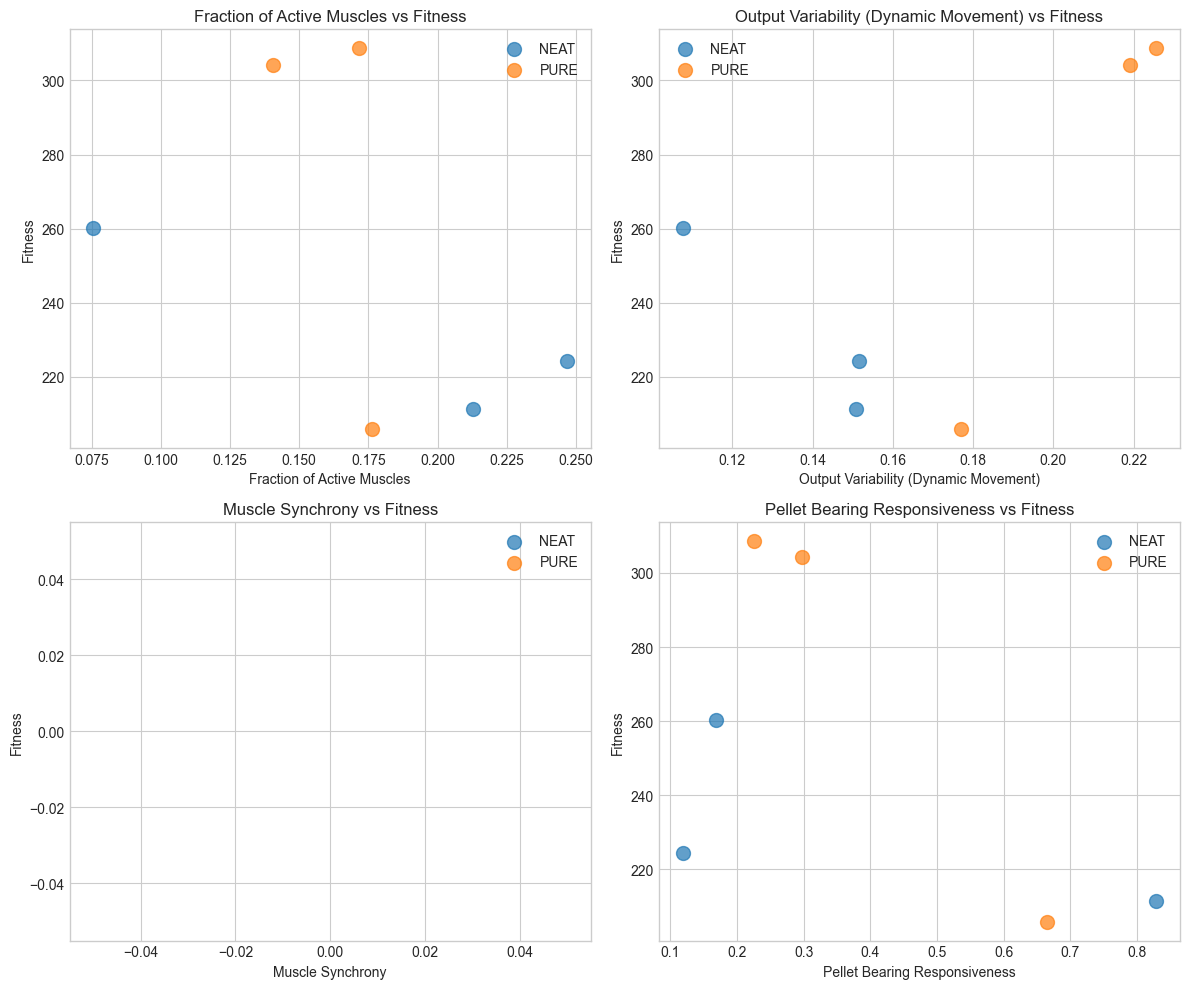

In [13]:
# Visualize strategy patterns
if len(strategy_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    metrics = [
        ('active_fraction', 'Fraction of Active Muscles'),
        ('output_variability', 'Output Variability (Dynamic Movement)'),
        ('muscle_synchrony', 'Muscle Synchrony'),
        ('pellet_responsiveness', 'Pellet Bearing Responsiveness'),
    ]
    
    for ax, (metric, title) in zip(axes.flat, metrics):
        if metric in strategy_df.columns:
            for mode in ['neat', 'pure']:
                subset = strategy_df[strategy_df['neural_mode'] == mode]
                if len(subset) > 0:
                    ax.scatter(subset[metric], subset['fitness'], 
                              label=mode.upper(), alpha=0.7, s=100)
            ax.set_xlabel(title)
            ax.set_ylabel('Fitness')
            ax.set_title(f'{title} vs Fitness')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

## 8. Deep Dive: Best Creature Analysis

Detailed analysis of the single best performing creature.

In [14]:
# Find best creature with frame data
best_row = creatures_with_frames.nlargest(1, 'fitness').iloc[0]
print(f"Best creature: {best_row['run_name']}")
print(f"  Fitness: {best_row['fitness']:.1f}")
print(f"  Pellets collected: {best_row['pellets']}")
print(f"  Neural mode: {best_row['neural_mode']}")
print(f"  Body: {best_row['node_count']} nodes, {best_row['muscle_count']} muscles")

Best creature: Pure Trial 159 (top-best)
  Fitness: 308.6
  Pellets collected: 3
  Neural mode: pure
  Body: 9 nodes, 13 muscles


In [15]:
# Load full frame data for best creature
best_frames = get_frames(best_row['creature_id'], best_row['run_id'], best_row['generation'])

print(f"Frame count: {best_frames['frame_count']}")
print(f"Frame rate: {best_frames['frame_rate']} FPS")
print(f"Duration: {best_frames['frame_count'] / best_frames['frame_rate']:.1f} seconds")

Frame count: 450
Frame rate: 15 FPS
Duration: 30.0 seconds


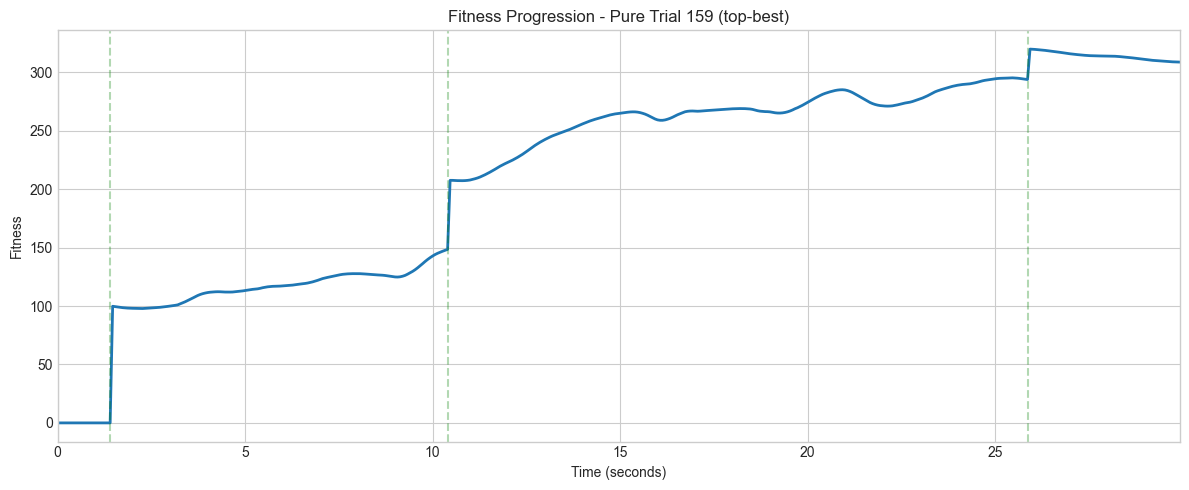

Pellet collection events detected: 3


In [16]:
# Plot fitness progression during simulation
fitness_over_time = best_frames.get('fitness_over_time', [])

if fitness_over_time:
    fig, ax = plt.subplots(figsize=(12, 5))
    
    time = np.arange(len(fitness_over_time)) / best_frames['frame_rate']
    ax.plot(time, fitness_over_time, linewidth=2)
    
    # Mark pellet collections (jumps in fitness)
    fitness_arr = np.array(fitness_over_time)
    diff = np.diff(fitness_arr)
    pellet_times = np.where(diff > 15)[0]  # Pellets give ~20 points
    
    for pt in pellet_times:
        ax.axvline(x=time[pt], color='green', alpha=0.3, linestyle='--')
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Fitness Progression - {best_row["run_name"]}')
    ax.set_xlim(0, time[-1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"Pellet collection events detected: {len(pellet_times)}")
else:
    print("No fitness over time data available")

In [17]:
# Analyze best creature's neural genome
genome = best_row['genome']
neural = genome.get('neuralGenome', {})

print("Neural Genome Structure:")
print(f"  Hidden size: {neural.get('hidden_size', 'N/A')}")
print(f"  Activation: {neural.get('activation', 'N/A')}")

if best_row['neural_mode'] == 'pure':
    weights_ih = np.array(neural.get('weights_ih', []))
    weights_ho = np.array(neural.get('weights_ho', []))
    
    if len(weights_ih) > 0:
        print(f"\n  Input->Hidden weights: {len(weights_ih)}")
        print(f"    Mean: {weights_ih.mean():.3f}, Std: {weights_ih.std():.3f}")
        print(f"    Range: [{weights_ih.min():.3f}, {weights_ih.max():.3f}]")
    
    if len(weights_ho) > 0:
        print(f"\n  Hidden->Output weights: {len(weights_ho)}")
        print(f"    Mean: {weights_ho.mean():.3f}, Std: {weights_ho.std():.3f}")
        print(f"    Range: [{weights_ho.min():.3f}, {weights_ho.max():.3f}]")
else:
    neat = genome.get('neat', {})
    connections = neat.get('connections', [])
    hidden_nodes = neat.get('hidden_nodes', [])
    
    print(f"\n  NEAT hidden nodes: {len(hidden_nodes)}")
    print(f"  Total connections: {len(connections)}")
    enabled = sum(1 for c in connections if c.get('enabled', True))
    print(f"  Enabled connections: {enabled}")
    
    if connections:
        weights = [c['weight'] for c in connections]
        print(f"\n  Weight stats:")
        print(f"    Mean: {np.mean(weights):.3f}, Std: {np.std(weights):.3f}")
        print(f"    Range: [{min(weights):.3f}, {max(weights):.3f}]")

Neural Genome Structure:
  Hidden size: 24
  Activation: tanh

  Input->Hidden weights: 744
    Mean: 0.044, Std: 1.279
    Range: [-4.549, 4.915]

  Hidden->Output weights: 312
    Mean: 0.020, Std: 1.147
    Range: [-3.567, 3.907]


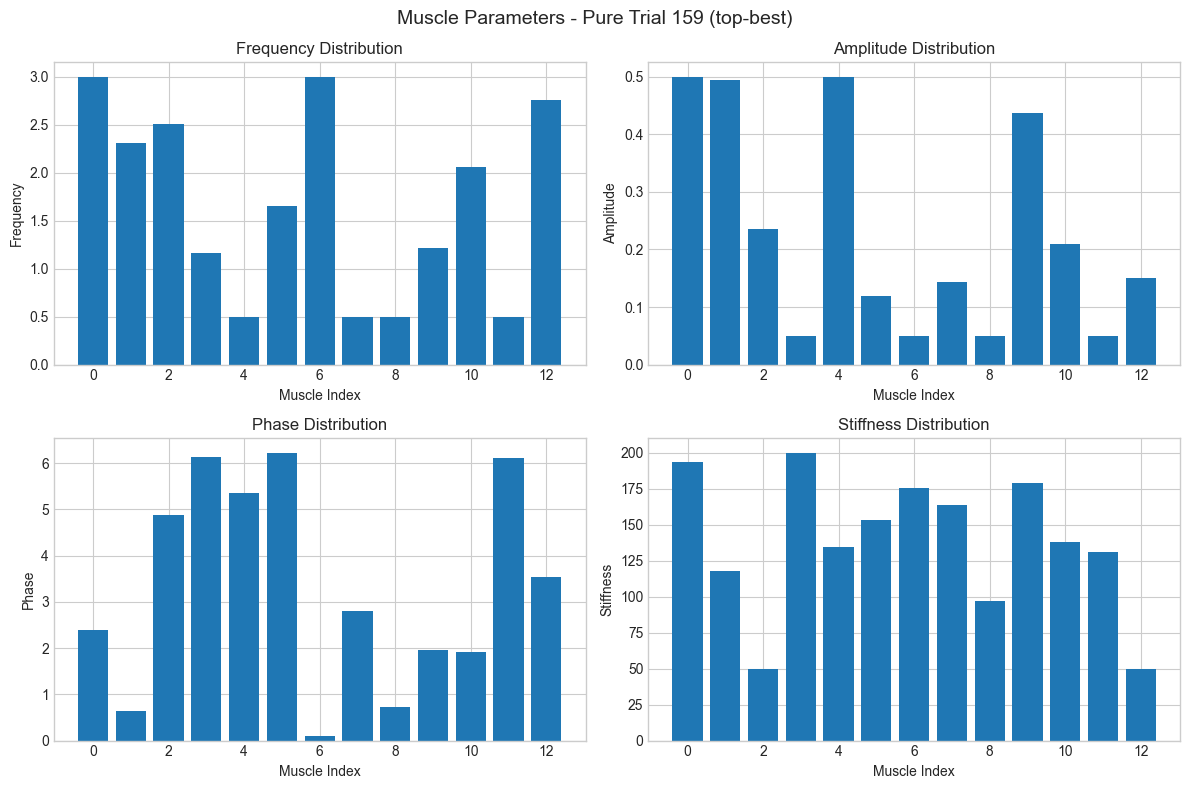


Muscle Parameter Statistics:
       frequency  amplitude      phase   stiffness
count  13.000000  13.000000  13.000000   13.000000
mean    1.666662   0.230009   3.287865  137.178824
std     0.996472   0.185963   2.236199   48.821500
min     0.500000   0.050000   0.103502   50.000000
25%     0.500000   0.050000   1.907580  117.778670
50%     1.649504   0.150775   2.795788  137.733180
75%     2.503721   0.436666   5.359258  175.640738
max     3.000000   0.500000   6.224490  200.000000


In [18]:
# Visualize muscle parameters of best creature
muscles = genome.get('muscles', [])

muscle_data = []
for m in muscles:
    muscle_data.append({
        'frequency': m.get('frequency', 0),
        'amplitude': m.get('amplitude', 0),
        'phase': m.get('phase', 0),
        'stiffness': m.get('stiffness', 0),
    })

muscle_df = pd.DataFrame(muscle_data)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.flat, ['frequency', 'amplitude', 'phase', 'stiffness']):
    ax.bar(range(len(muscle_df)), muscle_df[col])
    ax.set_xlabel('Muscle Index')
    ax.set_ylabel(col.capitalize())
    ax.set_title(f'{col.capitalize()} Distribution')

plt.suptitle(f'Muscle Parameters - {best_row["run_name"]}', fontsize=14)
plt.tight_layout()
plt.show()

print("\nMuscle Parameter Statistics:")
print(muscle_df.describe())

## 9. Learning Curves Comparison

Compare how different runs learned over generations.

In [19]:
# Load generation data for all NAS runs
learning_curves = {}

for run in nas_runs[:12]:  # Limit to avoid too many API calls
    try:
        gens = get_generations(run['id'])
        if gens:
            learning_curves[run['name']] = {
                'generations': [g['generation'] for g in gens],
                'best_fitness': [g['best_fitness'] for g in gens],
                'avg_fitness': [g['avg_fitness'] for g in gens],
                'neural_mode': run['config'].get('neural_mode'),
            }
    except Exception as e:
        print(f"Error: {e}")

print(f"Loaded learning curves for {len(learning_curves)} runs")

Loaded learning curves for 12 runs


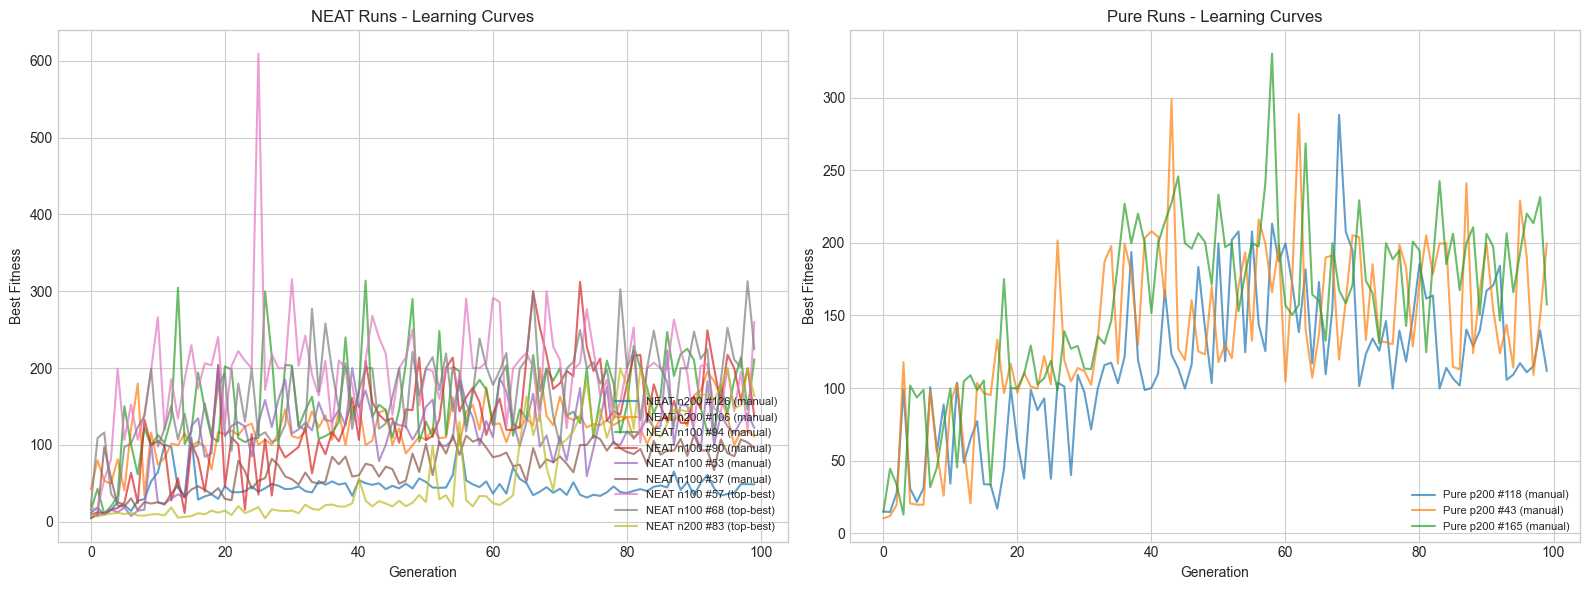

In [20]:
# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# NEAT runs
ax = axes[0]
for name, data in learning_curves.items():
    if data['neural_mode'] == 'neat':
        ax.plot(data['generations'], data['best_fitness'], alpha=0.7, label=name[:25])
ax.set_xlabel('Generation')
ax.set_ylabel('Best Fitness')
ax.set_title('NEAT Runs - Learning Curves')
ax.legend(loc='lower right', fontsize=8)

# Pure runs
ax = axes[1]
for name, data in learning_curves.items():
    if data['neural_mode'] == 'pure':
        ax.plot(data['generations'], data['best_fitness'], alpha=0.7, label=name[:25])
ax.set_xlabel('Generation')
ax.set_ylabel('Best Fitness')
ax.set_title('Pure Runs - Learning Curves')
ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

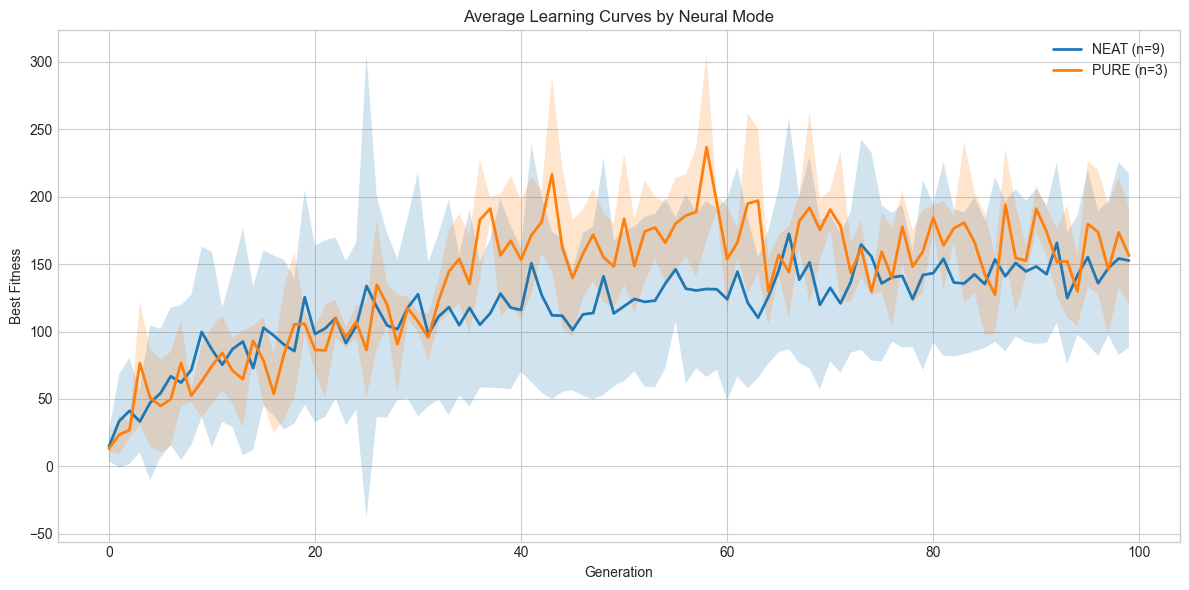

In [21]:
# Average learning curves by mode
fig, ax = plt.subplots(figsize=(12, 6))

for mode in ['neat', 'pure']:
    mode_curves = [data for data in learning_curves.values() if data['neural_mode'] == mode]
    
    if mode_curves:
        # Align to same length (min generations)
        min_len = min(len(c['best_fitness']) for c in mode_curves)
        aligned = np.array([c['best_fitness'][:min_len] for c in mode_curves])
        
        mean_curve = aligned.mean(axis=0)
        std_curve = aligned.std(axis=0)
        gens = range(min_len)
        
        ax.plot(gens, mean_curve, label=f'{mode.upper()} (n={len(mode_curves)})', linewidth=2)
        ax.fill_between(gens, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)

ax.set_xlabel('Generation')
ax.set_ylabel('Best Fitness')
ax.set_title('Average Learning Curves by Neural Mode')
ax.legend()
plt.tight_layout()
plt.show()

## 10. Key Findings Summary

In [22]:
print("="*60)
print("NAS CREATURE ANALYSIS - KEY FINDINGS")
print("="*60)

print(f"\n1. DATASET OVERVIEW")
print(f"   Total NAS runs analyzed: {len(nas_runs)}")
print(f"   NEAT runs: {len(neat_runs)}")
print(f"   Pure runs: {len(pure_runs)}")

print(f"\n2. FITNESS COMPARISON")
neat_fitness = runs_df[runs_df['neural_mode'] == 'neat']['best_fitness']
pure_fitness = runs_df[runs_df['neural_mode'] == 'pure']['best_fitness']
print(f"   NEAT - Mean: {neat_fitness.mean():.1f}, Max: {neat_fitness.max():.1f}")
print(f"   Pure - Mean: {pure_fitness.mean():.1f}, Max: {pure_fitness.max():.1f}")

print(f"\n3. MORPHOLOGY PATTERNS")
print(f"   Avg nodes - NEAT: {creatures_df[creatures_df['neural_mode']=='neat']['node_count'].mean():.1f}")
print(f"   Avg nodes - Pure: {creatures_df[creatures_df['neural_mode']=='pure']['node_count'].mean():.1f}")
print(f"   Avg muscles - NEAT: {creatures_df[creatures_df['neural_mode']=='neat']['muscle_count'].mean():.1f}")
print(f"   Avg muscles - Pure: {creatures_df[creatures_df['neural_mode']=='pure']['muscle_count'].mean():.1f}")

print(f"\n4. TOP PERFORMERS")
top5 = creatures_df.nlargest(5, 'fitness')[['run_name', 'fitness', 'neural_mode', 'node_count', 'muscle_count']]
for idx, row in top5.iterrows():
    print(f"   {row['run_name'][:35]:35} | {row['fitness']:6.1f} | {row['neural_mode']:4} | {row['node_count']}n/{row['muscle_count']}m")

if len(strategy_df) > 0:
    print(f"\n5. STRATEGY INSIGHTS")
    print(f"   Avg output variability: {strategy_df['output_variability'].mean():.3f}")
    print(f"   Avg muscle synchrony: {strategy_df['muscle_synchrony'].mean():.3f}")
    if 'dominant_freq' in strategy_df.columns:
        print(f"   Dominant locomotion frequency: {strategy_df['dominant_freq'].mean():.2f} Hz")

NAS CREATURE ANALYSIS - KEY FINDINGS

1. DATASET OVERVIEW
   Total NAS runs analyzed: 18
   NEAT runs: 10
   Pure runs: 8

2. FITNESS COMPARISON
   NEAT - Mean: 265.8, Max: 609.5
   Pure - Mean: 308.5, Max: 431.7

3. MORPHOLOGY PATTERNS
   Avg nodes - NEAT: 7.3
   Avg nodes - Pure: 7.0
   Avg muscles - NEAT: 9.2
   Avg muscles - Pure: 10.0

4. TOP PERFORMERS
   Pure Trial 159 (top-best)           |  308.6 | pure | 9n/13m
   Pure Trial 190 (top-best)           |  304.2 | pure | 7n/9m
   NEAT n100 #57 (top-best)            |  260.2 | neat | 8n/12m
   NEAT n100 #68 (top-best)            |  224.3 | neat | 7n/9m
   NEAT n100 #94 (manual)              |  211.4 | neat | 9n/12m

5. STRATEGY INSIGHTS
   Avg output variability: 0.172
   Avg muscle synchrony: nan
   Dominant locomotion frequency: 0.13 Hz
